In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## **Code Block 8.1:**
**Mean Reverting Time-Series**

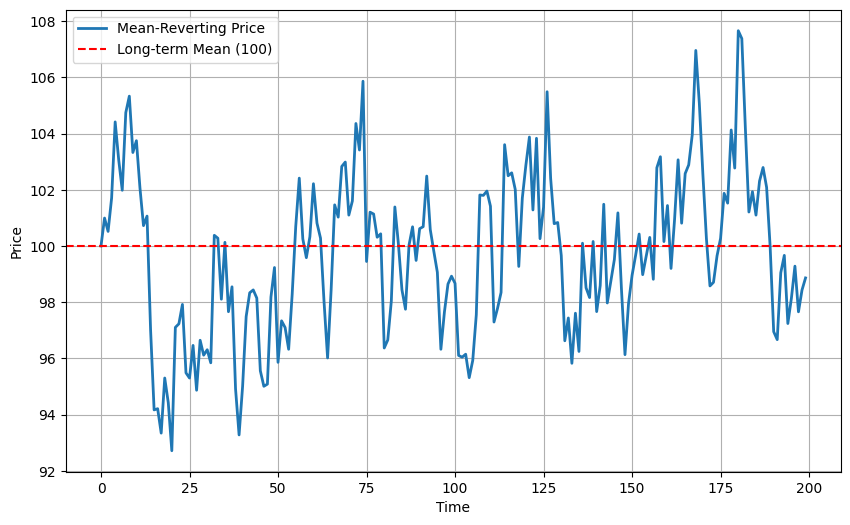

In [ ]:
def create_mean_reverting_series():
    np.random.seed(42)
    n_points = 200
    time = np.arange(n_points)

    prices = [100]
    for i in range(1, n_points):
        mean_reversion = 0.2 * (100 - prices[-1])
        random_shock = np.random.normal(0, 2)
        new_price = prices[-1] + mean_reversion + random_shock
        prices.append(new_price)

    return pd.Series(prices, index=time)

mr_series = create_mean_reverting_series()

plt.figure(figsize=(10, 6))
plt.plot(mr_series, label='Mean-Reverting Price', linewidth=2)
plt.axhline(y=100, color='red', linestyle='--', label='Long-term Mean (100)')
# plt.title('Mean-Reverting Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## **Code Block 8.2:**
**Testing for Mean Reversion with ADF Test**

In [ ]:
def simple_adf_test(series, name="Series"):
    result = adfuller(series.dropna())

    print(f"=== ADF Test Results for {name} ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    if result[1] <= 0.05:
        print("CONCLUSION: Series is MEAN-REVERTING (reject null hypothesis)")
    else:
        print("CONCLUSION: Series is NOT mean-reverting (random walk)")
    print()

    return result

simple_adf_test(mr_series, "Artificial Mean-Reverting Series")

=== ADF Test Results for Artificial Mean-Reverting Series ===
ADF Statistic: -5.1486
p-value: 0.0000
Critical Values:
  1%: -3.4636
  5%: -2.8762
  10%: -2.5746
CONCLUSION: Series is MEAN-REVERTING (reject null hypothesis)



(np.float64(-5.148641237687071),
 np.float64(1.1182577477094307e-05),
 0,
 199,
 {'1%': np.float64(-3.4636447617687436),
  '5%': np.float64(-2.8761761179270766),
  '10%': np.float64(-2.57457158581854)},
 np.float64(751.263638643697))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


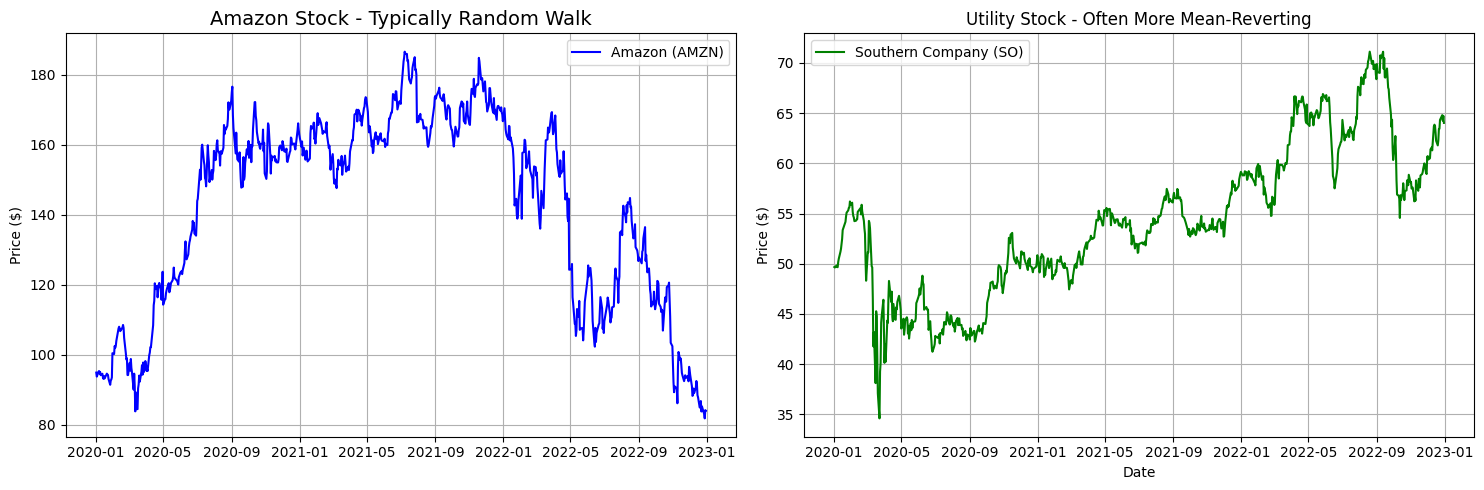

TESTING REAL STOCKS:
=== ADF Test Results for Amazon (AMZN) ===
ADF Statistic: -1.3941
p-value: 0.5851
Critical Values:
  1%: -3.4390
  5%: -2.8654
  10%: -2.5688
CONCLUSION: Series is NOT mean-reverting (random walk)

=== ADF Test Results for Southern Company (SO) ===
ADF Statistic: -1.2329
p-value: 0.6593
Critical Values:
  1%: -3.4392
  5%: -2.8654
  10%: -2.5688
CONCLUSION: Series is NOT mean-reverting (random walk)



(np.float64(-1.2329395582113847),
 np.float64(0.6592679166541593),
 13,
 742,
 {'1%': np.float64(-3.4391937559530965),
  '5%': np.float64(-2.8654430713273373),
  '10%': np.float64(-2.568848417404698)},
 np.float64(1963.9069735574074))

In [ ]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    return stock_data['Close']

# Amazon data
amzn = download_stock_data('AMZN', '2020-01-01', '2023-01-01')

# Download a utility stock (often more mean-reverting)
so = download_stock_data('SO', '2020-01-01', '2023-01-01')  # Southern Company

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # Changed to 1 row, 2 columns

# Amazon plot
ax1.plot(amzn, label='Amazon (AMZN)', color='blue')
ax1.set_title('Amazon Stock - Typically Random Walk', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid()

# Utility stock plot
ax2.plot(so, label='Southern Company (SO)', color='green')
ax2.set_title('Utility Stock - Often More Mean-Reverting')
ax2.set_ylabel('Price ($)')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

print("TESTING REAL STOCKS:")
simple_adf_test(amzn, "Amazon (AMZN)")
simple_adf_test(so, "Southern Company (SO)")

## **Code Block 8.3:**
**Hurst Exponent - Measuring Trendiness**

=== Hurst Exponent for Artificial Mean-Reverting Series ===
Hurst Value: 0.0565
MEAN-REVERTING: Tends to reverse direction

=== Hurst Exponent for Amazon (AMZN) ===
Hurst Value: 0.9056
TRENDING: Tends to continue in same direction

=== Hurst Exponent for Southern Company (SO) ===
Hurst Value: 0.5950
TRENDING: Tends to continue in same direction



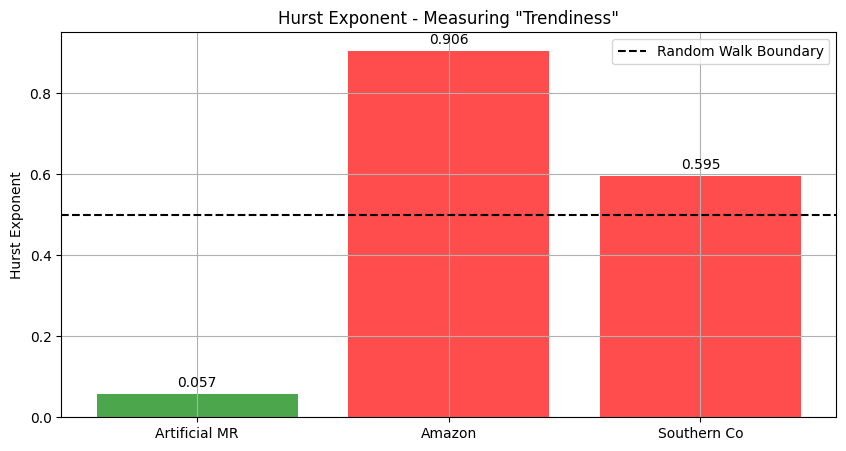

In [ ]:
def hurst_exponent_simple(ts):
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:].values, ts[:-lag].values)) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

def interpret_hurst(hurst_value, name):
    print(f"=== Hurst Exponent for {name} ===")
    print(f"Hurst Value: {hurst_value:.4f}")

    if hurst_value < 0.5:
        print("MEAN-REVERTING: Tends to reverse direction")
    elif hurst_value > 0.5:
        print("TRENDING: Tends to continue in same direction")
    else:
        print("RANDOM WALK: Unpredictable movement")
    print()

# Calculate for our examples
hurst_amzn = hurst_exponent_simple(amzn)
hurst_so = hurst_exponent_simple(so)
hurst_artificial = hurst_exponent_simple(mr_series)

interpret_hurst(hurst_artificial, "Artificial Mean-Reverting Series")
interpret_hurst(hurst_amzn, "Amazon (AMZN)")
interpret_hurst(hurst_so, "Southern Company (SO)")

plt.figure(figsize=(10, 5))
categories = ['Artificial MR', 'Amazon', 'Southern Co']
hurst_values = [hurst_artificial, hurst_amzn, hurst_so]
colors = ['green' if x < 0.5 else 'red' if x > 0.5 else 'gray' for x in hurst_values]

bars = plt.bar(categories, hurst_values, color=colors, alpha=0.7)
plt.axhline(y=0.5, color='black', linestyle='--', label='Random Walk Boundary')
plt.ylabel('Hurst Exponent')
plt.title('Hurst Exponent - Measuring "Trendiness"')
plt.legend()
plt.grid()

for bar, value in zip(bars, hurst_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Correlation between KO and PEP: 0.9304


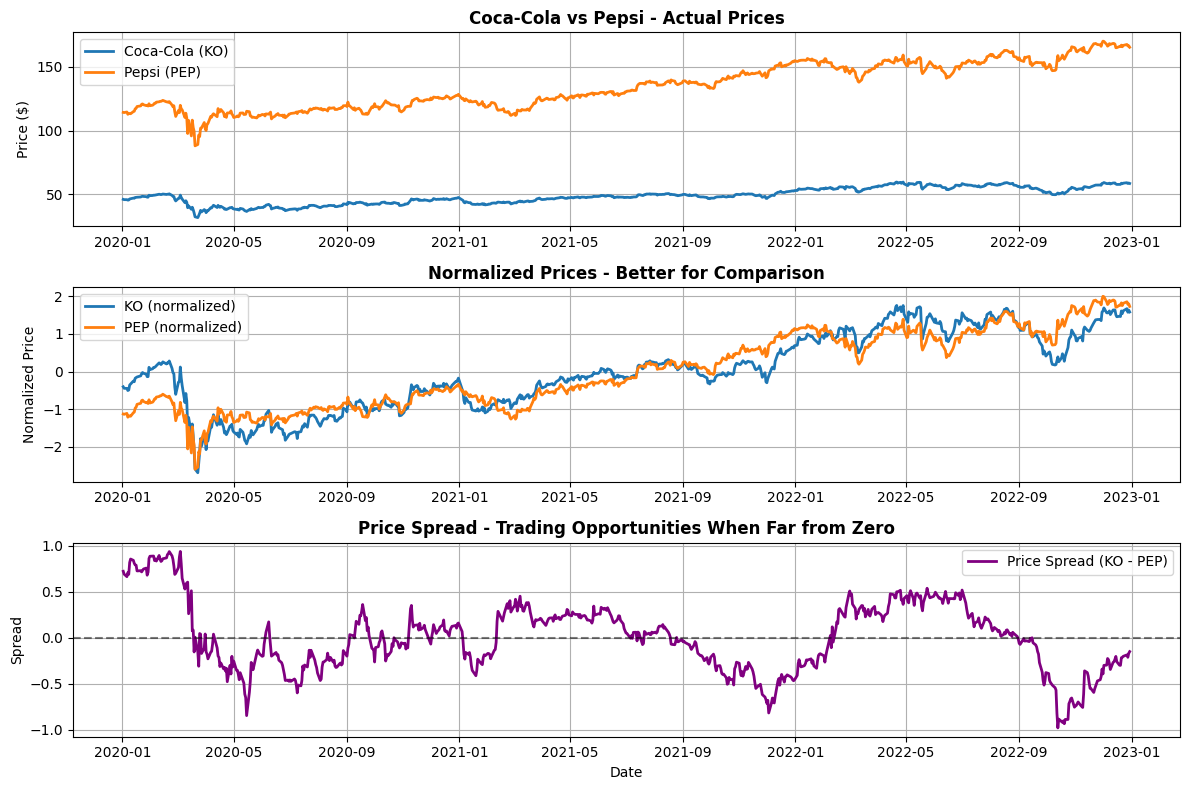

TESTING THE SPREAD FOR PAIRS TRADING:
=== ADF Test Results for KO-PEP Spread ===
ADF Statistic: -3.0724
p-value: 0.0287
Critical Values:
  1%: -3.4392
  5%: -2.8654
  10%: -2.5688
CONCLUSION: Series is MEAN-REVERTING (reject null hypothesis)

=== Hurst Exponent for KO-PEP Spread ===
Hurst Value: 0.9305
TRENDING: Tends to continue in same direction



In [ ]:
def analyze_pair(stock1_ticker, stock2_ticker, start_date, end_date):
    stock1 = download_stock_data(stock1_ticker, start_date, end_date)
    stock2 = download_stock_data(stock2_ticker, start_date, end_date)

    if stock1.empty or stock2.empty:
        print(f"Warning: No data or empty series for {stock1_ticker} or {stock2_ticker}. Cannot form a pair.")
        # Return an empty DataFrame, normalized empty DataFrame, and correlation of 0
        empty_df = pd.DataFrame(columns=[stock1_ticker, stock2_ticker])
        empty_norm_df = pd.DataFrame(columns=[stock1_ticker, stock2_ticker, 'spread'])
        return empty_df, empty_norm_df, 0.0

    # Explicitly set the name of the series to be used as column headers after concat
    stock1.name = stock1_ticker
    stock2.name = stock2_ticker

    # Create DataFrame by concatenating named series
    pair_data = pd.concat([stock1, stock2], axis=1).dropna()

    # If after dropna, the pair_data is empty, then also return empty results
    if pair_data.empty:
        print(f"Warning: No common data points after aligning and dropping NaNs for {stock1_ticker} and {stock2_ticker}. Cannot form a pair.")
        empty_norm_df = pd.DataFrame(columns=[stock1_ticker, stock2_ticker, 'spread'])
        return pair_data, empty_norm_df, 0.0

    # Calculate correlation
    correlation = pair_data.corr().iloc[0,1]

    # Calculate spread (price difference)
    # First, normalize prices to make them comparable
    pair_data_norm = (pair_data - pair_data.mean()) / pair_data.std()
    pair_data_norm['spread'] = pair_data_norm[stock1_ticker] - pair_data_norm[stock2_ticker]

    return pair_data, pair_data_norm, correlation

# Analyze Coca-Cola vs Pepsi (similar businesses)
pair_data, pair_data_norm, correlation = analyze_pair('KO', 'PEP', '2020-01-01', '2023-01-01')
print(f"Correlation between KO and PEP: {correlation:.4f}")

if not pair_data.empty:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

    # Actual prices
    ax1.plot(pair_data.index, pair_data['KO'], label='Coca-Cola (KO)', linewidth=2)
    ax1.plot(pair_data.index, pair_data['PEP'], label='Pepsi (PEP)', linewidth=2)
    ax1.set_title('Coca-Cola vs Pepsi - Actual Prices', fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid()

    # Normalized prices
    ax2.plot(pair_data_norm.index, pair_data_norm['KO'], label='KO (normalized)', linewidth=2)
    ax2.plot(pair_data_norm.index, pair_data_norm['PEP'], label='PEP (normalized)', linewidth=2)
    ax2.set_title('Normalized Prices - Better for Comparison', fontweight='bold')
    ax2.set_ylabel('Normalized Price')
    ax2.legend()
    ax2.grid()

    # Spread between them
    ax3.plot(pair_data_norm.index, pair_data_norm['spread'], label='Price Spread (KO - PEP)',
             color='purple', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('Price Spread - Trading Opportunities When Far from Zero', fontweight='bold')
    ax3.set_ylabel('Spread')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid()

    plt.tight_layout()
    plt.show()

    print("TESTING THE SPREAD FOR PAIRS TRADING:")
    spread_series = pair_data_norm['spread']
    simple_adf_test(spread_series, "KO-PEP Spread")

    hurst_spread = hurst_exponent_simple(spread_series)
    interpret_hurst(hurst_spread, "KO-PEP Spread")
else:
    print("Skipping plots and further analysis due to empty pair data.")

## **Code Block 8.4:**
**Simple pairs trading strategy: When spread is too high, short stock1 and long stock2, When spread is too low, long stock1 and short stock2**

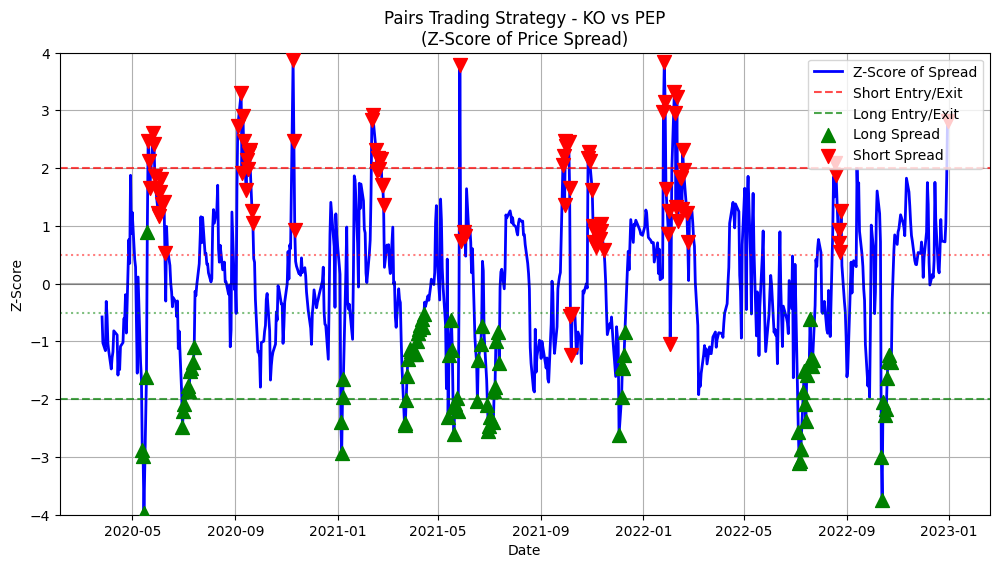

Strategy Summary:
Number of Long Entries: 88
Number of Short Entries: 93
Maximum Z-Score: 3.88
Minimum Z-Score: -3.97


In [ ]:
def simple_pairs_trading_strategy(stock1, stock2, lookback_days=30):
    norm_stock1 = (stock1 - stock1.rolling(window=lookback_days).mean()) / stock1.rolling(window=lookback_days).std()
    norm_stock2 = (stock2 - stock2.rolling(window=lookback_days).mean()) / stock2.rolling(window=lookback_days).std()

    # Calculate spread
    spread = norm_stock1 - norm_stock2

    # Calculate z-score of spread
    spread_mean = spread.rolling(window=lookback_days).mean()
    spread_std = spread.rolling(window=lookback_days).std()
    z_score = (spread - spread_mean) / spread_std

    # Generate signals
    signals = pd.DataFrame(index=stock1.index)
    signals['z_score'] = z_score
    signals['position'] = 0

    # Entry/exit thresholds
    entry_threshold = 2.0
    exit_threshold = 0.5

    # Generate trading signals
    for i in range(1, len(signals)):
        if signals['z_score'].iloc[i] > entry_threshold:
            signals.loc[signals.index[i], 'position'] = -1
        elif signals['z_score'].iloc[i] < -entry_threshold:
            signals.loc[signals.index[i], 'position'] = 1
        elif abs(signals['z_score'].iloc[i]) < exit_threshold:
            signals.loc[signals.index[i], 'position'] = 0
        else:
            signals.loc[signals.index[i], 'position'] = signals['position'].iloc[i-1]

    return signals

signals = simple_pairs_trading_strategy(pair_data['KO'], pair_data['PEP'])

plt.figure(figsize=(12, 6))

plt.plot(signals.index, signals['z_score'], label='Z-Score of Spread', linewidth=2, color='blue')
plt.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Short Entry/Exit')
plt.axhline(y=-2, color='green', linestyle='--', alpha=0.7, label='Long Entry/Exit')
plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.5)
plt.axhline(y=-0.5, color='green', linestyle=':', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add position markers
long_entries = signals[signals['position'] == 1]
short_entries = signals[signals['position'] == -1]
exits = signals[signals['position'] == 0]

plt.scatter(long_entries.index, long_entries['z_score'], color='green',
           marker='^', s=100, label='Long Spread', zorder=5)
plt.scatter(short_entries.index, short_entries['z_score'], color='red',
           marker='v', s=100, label='Short Spread', zorder=5)

plt.title('Pairs Trading Strategy - KO vs PEP\n(Z-Score of Price Spread)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.ylim(-4, 4)
plt.show()

print("Strategy Summary:")
print(f"Number of Long Entries: {len(long_entries)}")
print(f"Number of Short Entries: {len(short_entries)}")
print(f"Maximum Z-Score: {signals['z_score'].max():.2f}")
print(f"Minimum Z-Score: {signals['z_score'].min():.2f}")

## **Code Block 8.5:**
**Statistical Arbitrage Foundations: Identifying Cointegrated Pairs**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

TEST 1: Coca-Cola vs Pepsi


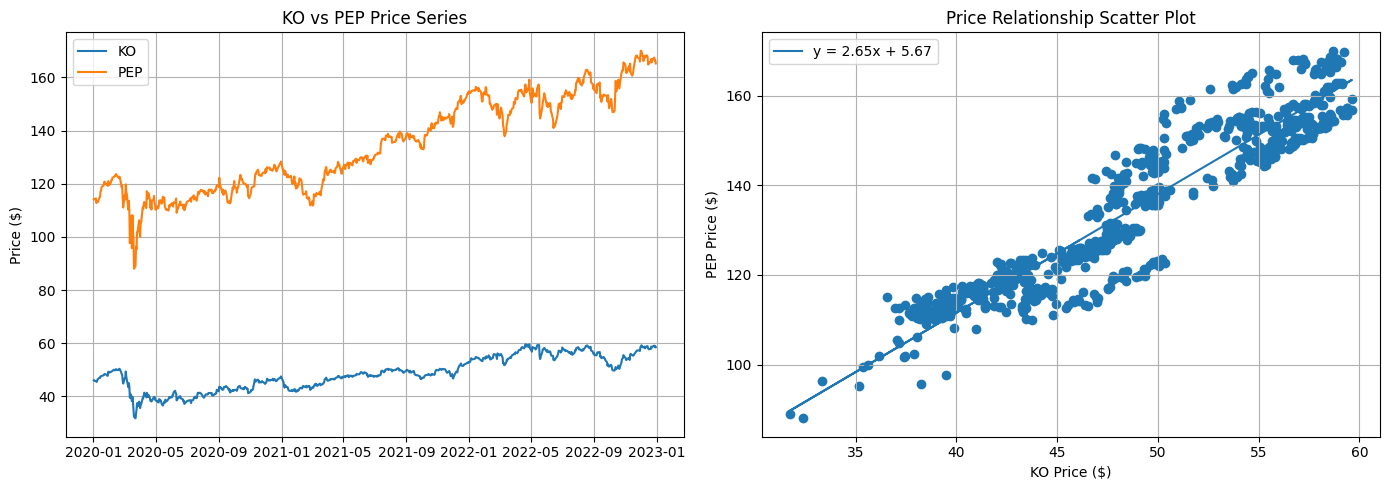


Calculating optimal hedge ratio via OLS
Regression Results:
  Hedge Ratio (β): 2.6473
  Intercept: 5.6692
  R-squared: 0.8657
  Equation: PEP = 5.67 + 2.65×KO

Testing spread for stationarity


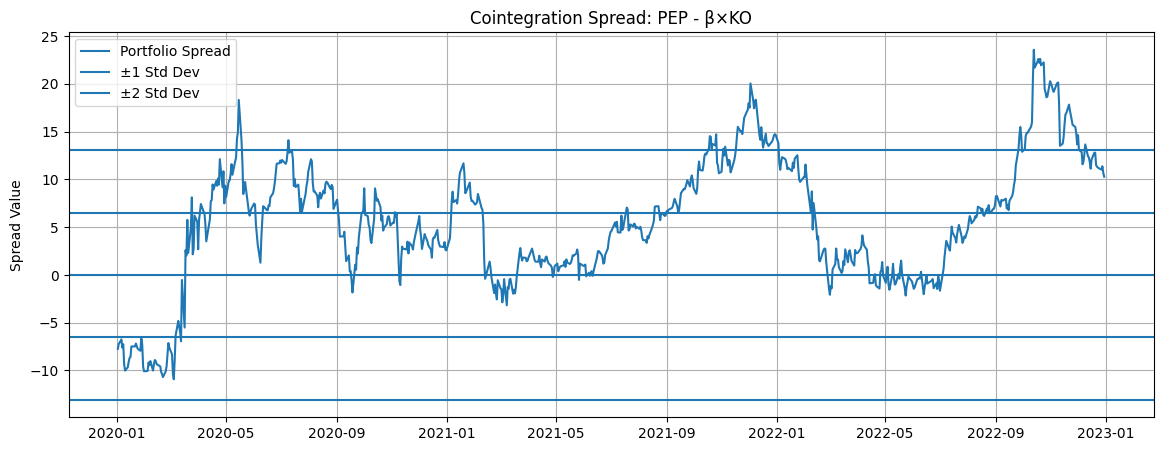

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CADF Test Results:
ADF Statistic: -2.9181
p-value: 0.0433
Critical Values:
  1%: -3.4392
  5%: -2.8654
  10%: -2.5688

CONCLUSION: Series are COINTEGRATED - Suitable for pairs trading!

Trading Parameters:
  Spread Mean: 5.67
  Spread Std: 6.53
  Suggested entry: ±1.5-2 standard deviations from mean


Microsoft vs Apple


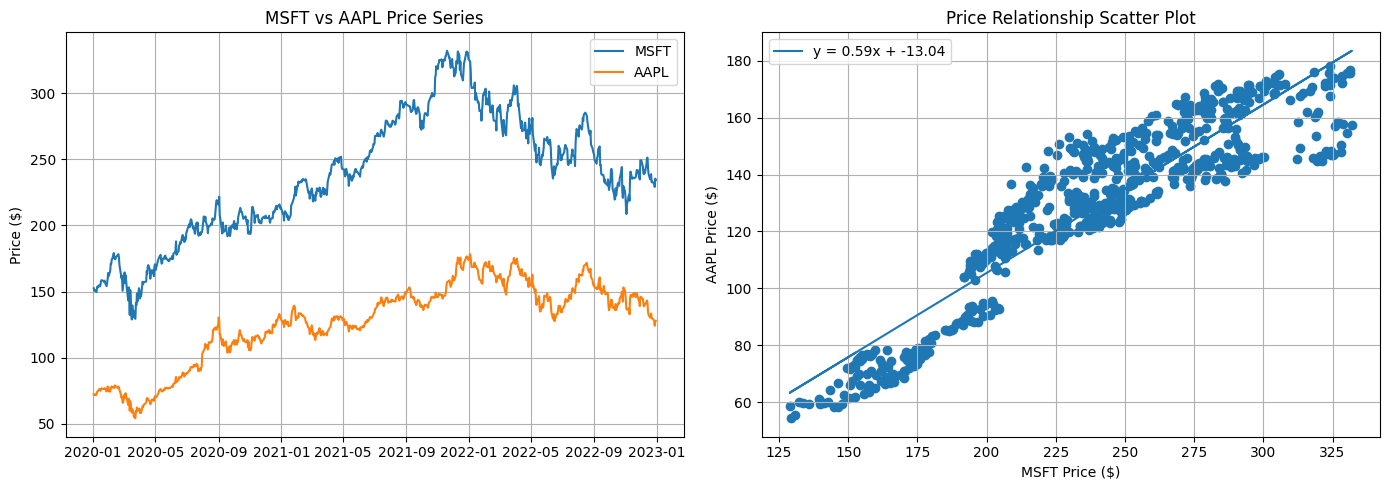


Calculating optimal hedge ratio via OLS
Regression Results:
  Hedge Ratio (β): 0.5922
  Intercept: -13.0438
  R-squared: 0.8409
  Equation: AAPL = -13.04 + 0.59×MSFT

Testing spread for stationarity


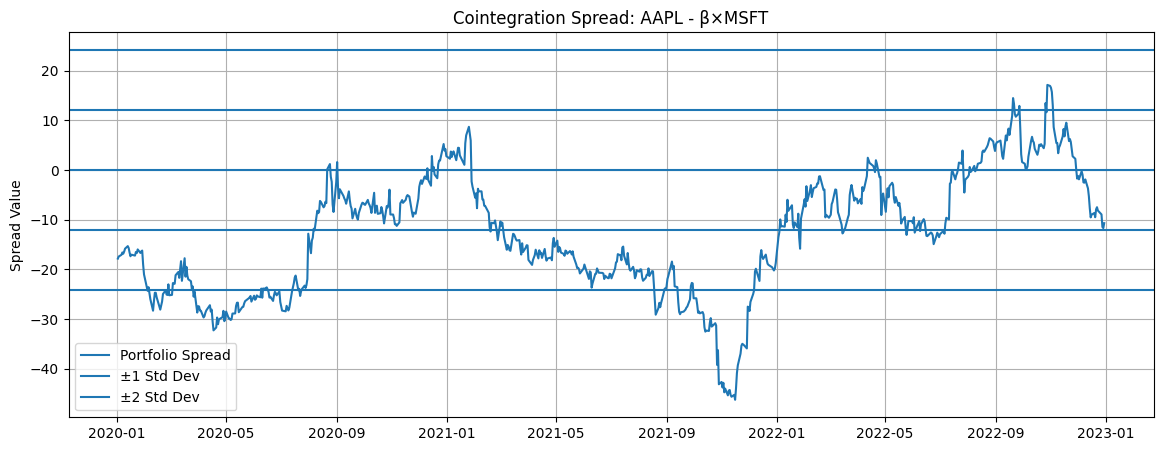

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CADF Test Results:
ADF Statistic: -1.9548
p-value: 0.3068
Critical Values:
  1%: -3.4392
  5%: -2.8654
  10%: -2.5688

CONCLUSION: Series are NOT cointegrated


Amazon vs Exxon (Different Sectors)


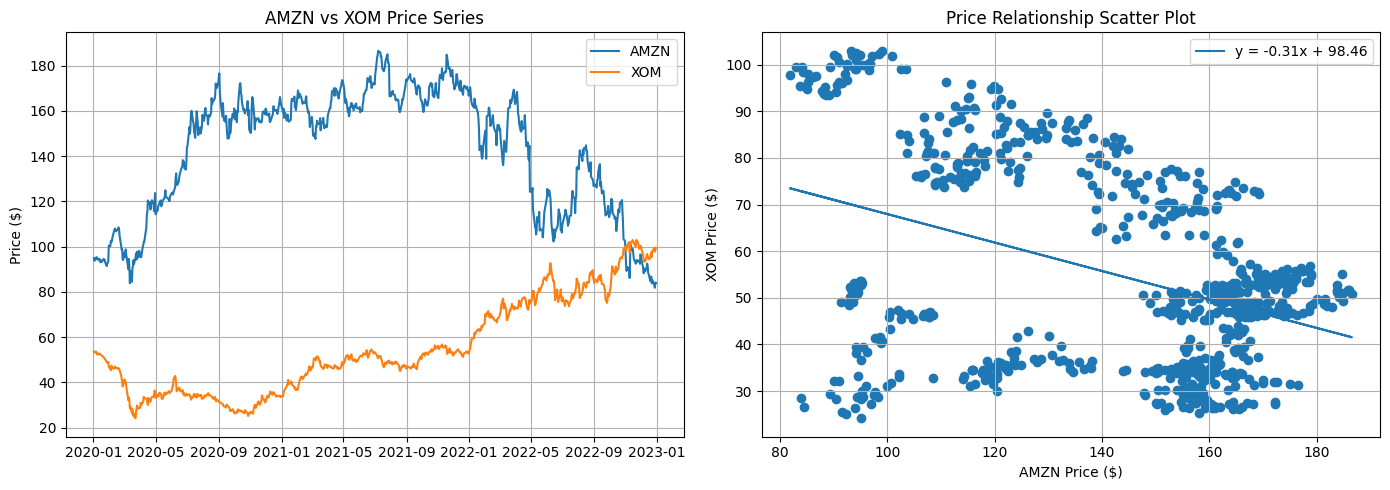


Calculating optimal hedge ratio via OLS
Regression Results:
  Hedge Ratio (β): -0.3051
  Intercept: 98.4573
  R-squared: 0.1628
  Equation: XOM = 98.46 + -0.31×AMZN

Testing spread for stationarity


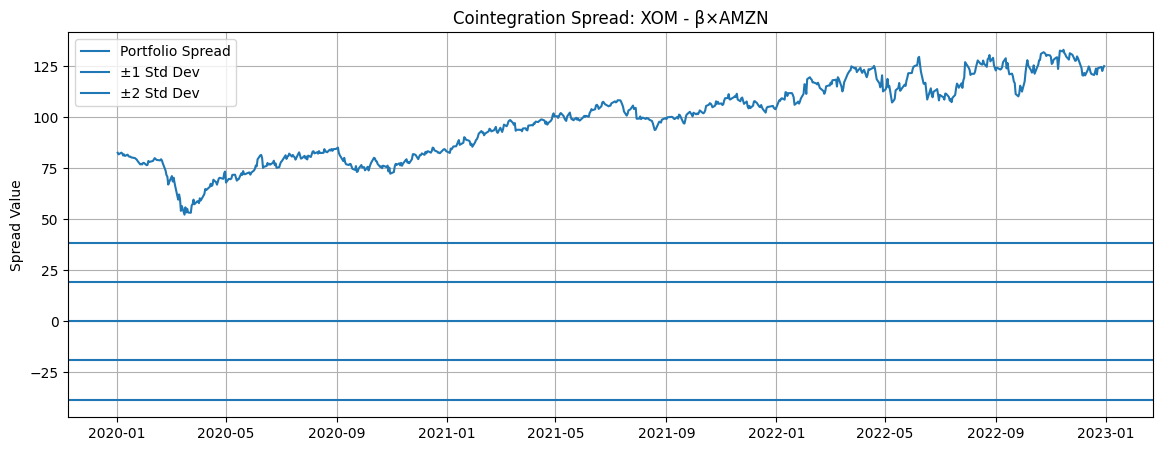

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CADF Test Results:
ADF Statistic: -0.9589
p-value: 0.7680
Critical Values:
  1%: -3.4391
  5%: -2.8654
  10%: -2.5688

CONCLUSION: Series are NOT cointegrated


JPMorgan vs Bank of America


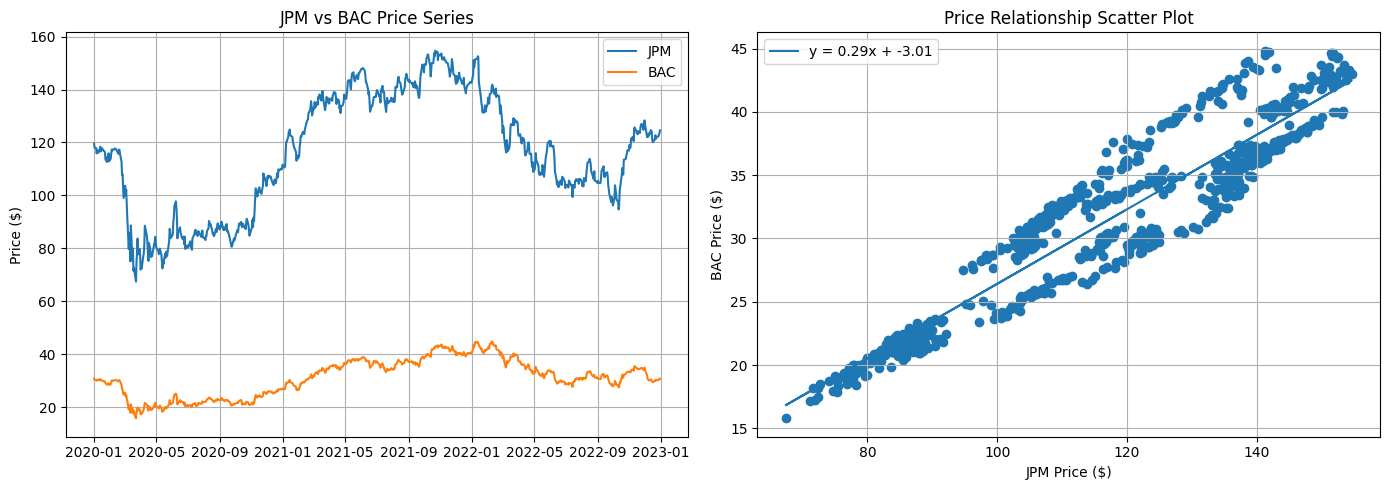


Calculating optimal hedge ratio via OLS
Regression Results:
  Hedge Ratio (β): 0.2942
  Intercept: -3.0102
  R-squared: 0.8793
  Equation: BAC = -3.01 + 0.29×JPM

Testing spread for stationarity


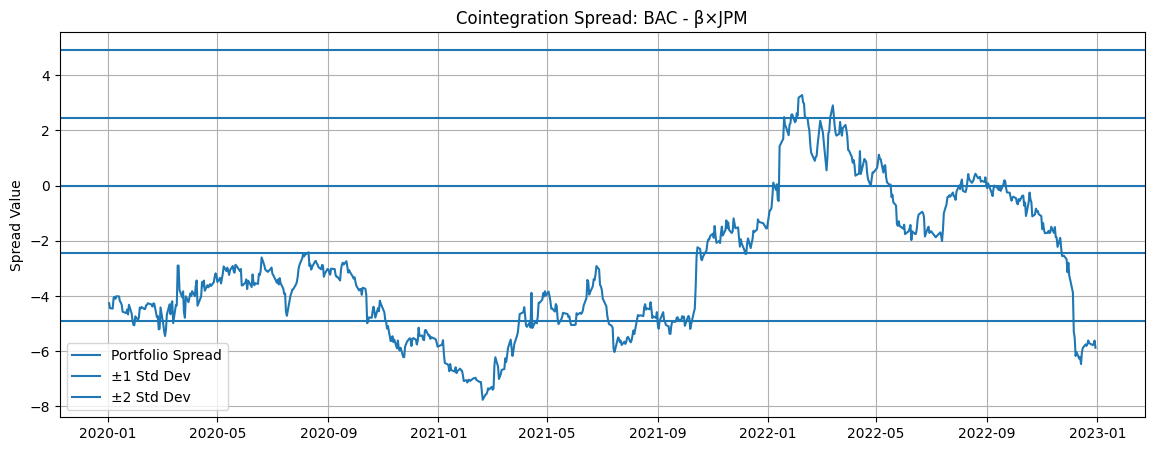


CADF Test Results:
ADF Statistic: -1.4331
p-value: 0.5663
Critical Values:
  1%: -3.4390
  5%: -2.8654
  10%: -2.5688

CONCLUSION: Series are NOT cointegrated

SUMMARY OF RESULTS
KO-PEP: COINTEGRATED (β = 2.6473)
MSFT-AAPL: NOT cointegrated (β = 0.5922)
AMZN-XOM: NOT cointegrated (β = -0.3051)
JPM-BAC: NOT cointegrated (β = 0.2942)


In [ ]:
def cointegration_analysis(stock1_ticker, stock2_ticker, start_date, end_date):
    data1 = yf.download(stock1_ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
    data2 = yf.download(stock2_ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
    data1.name = stock1_ticker
    data2.name = stock2_ticker

    df = pd.concat([data1, data2], axis=1).dropna()
    plot_relationship(df, stock1_ticker, stock2_ticker)

    print("\nCalculating optimal hedge ratio via OLS")
    X = df[stock1_ticker]
    y = df[stock2_ticker]
    X_with_const = sm.add_constant(X)

    model = OLS(y, X_with_const).fit()
    beta = model.params.iloc[1]
    intercept = model.params.iloc[0]

    print(f"Regression Results:")
    print(f"  Hedge Ratio (β): {beta:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  R-squared: {model.rsquared:.4f}")
    print(f"  Equation: {stock2_ticker} = {intercept:.2f} + {beta:.2f}×{stock1_ticker}")

    df['spread'] = df[stock2_ticker] - beta * df[stock1_ticker]
    print("\nTesting spread for stationarity")
    plot_spread(df, stock1_ticker, stock2_ticker)

    # ADF test on the spread
    adf_result = adfuller(df['spread'].dropna())

    print("\nCADF Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.4f}")

    # Enhanced interpretation
    print("\n" + "="*50)
    if adf_result[1] <= 0.05:
        print("CONCLUSION: Series are COINTEGRATED - Suitable for pairs trading!")
        spread_stats = df['spread'].describe()
        print(f"\nTrading Parameters:")
        print(f"  Spread Mean: {df['spread'].mean():.2f}")
        print(f"  Spread Std: {df['spread'].std():.2f}")
        print(f"  Suggested entry: ±1.5-2 standard deviations from mean")
        return True, beta, df
    else:
        print("CONCLUSION: Series are NOT cointegrated")
        return False, beta, df

def plot_relationship(df, stock1, stock2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Price series plot
    ax1.plot(df.index, df[stock1], label=stock1)
    ax1.plot(df.index, df[stock2], label=stock2)
    ax1.set_title(f'{stock1} vs {stock2} Price Series')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid()

    # Scatter plot
    ax2.scatter(df[stock1], df[stock2])
    ax2.set_xlabel(f'{stock1} Price ($)')
    ax2.set_ylabel(f'{stock2} Price ($)')
    ax2.set_title('Price Relationship Scatter Plot')
    ax2.grid()

    # Regression line
    z = np.polyfit(df[stock1], df[stock2], 1)
    p = np.poly1d(z)
    ax2.plot(df[stock1], p(df[stock1]), label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_spread(df, stock1, stock2):
    plt.figure(figsize=(14, 5))
    spread = df['spread']

    plt.plot(df.index, spread, label='Portfolio Spread')
    plt.axhline(y=0)
    plt.axhline(y=spread.std(), label='±1 Std Dev')
    plt.axhline(y=-spread.std())
    plt.axhline(y=2*spread.std(), label='±2 Std Dev')
    plt.axhline(y=-2*spread.std())

    plt.title(f'Cointegration Spread: {stock2} - β×{stock1}')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    print("TEST 1: Coca-Cola vs Pepsi")
    print("="*60)
    is_cointegrated1, beta1, results_df1 = cointegration_analysis('KO', 'PEP', '2020-01-01', '2023-01-01')

    print("\n" + "="*60 + "\n")

    print("Microsoft vs Apple")
    print("="*60)
    is_cointegrated2, beta2, results_df2 = cointegration_analysis('MSFT', 'AAPL', '2020-01-01', '2023-01-01')

    print("\n" + "="*60 + "\n")

    print("Amazon vs Exxon")
    print("="*60)
    is_cointegrated3, beta3, results_df3 = cointegration_analysis('AMZN', 'XOM', '2020-01-01', '2023-01-01')

    print("\n" + "="*60 + "\n")

    print("JPMorgan vs Bank of America")
    print("="*60)
    is_cointegrated4, beta4, results_df4 = cointegration_analysis('JPM', 'BAC', '2020-01-01', '2023-01-01')

    print("\n" + "="*60)
    print("SUMMARY OF RESULTS")
    print("="*60)
    pairs = [
        ('KO-PEP', is_cointegrated1, beta1),
        ('MSFT-AAPL', is_cointegrated2, beta2),
        ('AMZN-XOM', is_cointegrated3, beta3),
        ('JPM-BAC', is_cointegrated4, beta4)]

    for pair_name, is_coint, beta_val in pairs:
        status = "COINTEGRATED" if is_coint else "NOT cointegrated"
        print(f"{pair_name}: {status} (β = {beta_val:.4f})")

## **Code Block 8.6:**
**Data Loading, Feature Engineering, and Time Series Split**


In [6]:
def load_sp500_data(start_date='2010-01-01', end_date='2025-06-30'):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)
    sp500['returns'] = sp500['Close'].pct_change()
    sp500['direction'] = np.where(sp500['returns'] > 0, 1, 0) # Changed -1 to 0 for binary classification
    for lag in [1, 2, 3]:
        sp500[f'lag_{lag}_day'] = sp500['returns'].shift(lag)
    sp500_clean = sp500.dropna()
    print(f"Data loaded: {len(sp500_clean)} trading days")
    return sp500_clean

def split_data(X, y, date_split='2022-01-01'):
    X_train = X[X.index < date_split]
    X_test = X[X.index >= date_split]
    y_train = y[X.index < date_split]
    y_test = y[X.index >= date_split]

    print(f"Training period: {X_train.index.min().strftime('%Y-%m-%d')} to {X_train.index.max().strftime('%Y-%m-%d')} ({len(X_train)} samples)")
    print(f"Testing period:  {X_test.index.min().strftime('%Y-%m-%d')} to {X_test.index.max().strftime('%Y-%m-%d')} ({len(X_test)} samples)")

    return X_train, X_test, y_train, y_test

## **Code Block 8.7:**
**Price Direction: Multi-Model ML Benchmark (Framework Consist of 14 ML Models Ranging from Linear Models (Baseline), Tree-Based Ensembles, Support Vector Machines, Neural Networks, Gaussian Processes, Advanced Ensembles, Bayesian Models, Distance-Based, Ensemble Methods)**


In [8]:
def model_testing():
    data = load_sp500_data(start_date='2015-01-01', end_date='2024-06-30')

    features = ['lag_1_day', 'lag_2_day', 'lag_3_day']
    X = data[features]
    y = data['direction']
    X_train, X_test, y_train, y_test = split_data(X, y, date_split='2022-01-01')
    # print(f"   X_train shape: {X_train.shape}")
    # print(f"   X_test shape:  {X_test.shape}")
    # print(f"   y_train distribution: ↑{sum(y_train == 1)} days, ↓{sum(y_train == 0)} days")
    # print(f"   y_test distribution:  ↑{sum(y_test == 1)} days, ↓{sum(y_test == 0)} days")
    # print(X_train.head())
    # print(X_test.head())

    models = {
        # Linear models (baseline)
        'Logistic Regression': LogisticRegression(random_state = 42, max_iter = 1000),

        # Tree-based ensembles
        'Random Forest': RandomForestClassifier(n_estimators = 1000, random_state = 42),
        'XGBoost': XGBClassifier(n_estimators = 1000, learning_rate = 0.01, max_depth = 6, random_state = 42),
        'LightGBM': LGBMClassifier(n_estimators = 1000, learning_rate = 0.01, num_leaves=31, random_state = 42),

        # Support Vector Machines
        'SVM Linear': SVC(kernel = 'linear', probability = True, random_state = 42),
        'SVM RBF': SVC(kernel = 'rbf', probability = True, random_state = 42),
        'SVM Polynomial': SVC(kernel ='poly', degree=3, probability = True, random_state = 42),

        # Neural Networks
        'MLP Neural Network': MLPClassifier(hidden_layer_sizes = (100, 50), early_stopping = True,
                                          random_state = 42, max_iter = 1000),

        # Gaussian Processes
        'Gaussian Process': GaussianProcessClassifier(random_state = 42),

        # Advanced Ensembles
        'Gradient Boosting': GradientBoostingClassifier(n_estimators = 1000, learning_rate = 0.01,
                                                      random_state = 42),
        'AdaBoost': AdaBoostClassifier(n_estimators=500, random_state = 42),

        # Bayesian Models
        'Gaussian Naive Bayes': GaussianNB(),

        # Distance-based
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors = 15),

         # Ensemble methods
        'Voting Ensemble': VotingClassifier(
                estimators=[
                    ('xgb', XGBClassifier(n_estimators = 500, random_state = 42)),
                    ('rf', RandomForestClassifier(n_estimators = 500, random_state = 42)),
                    ('svm', SVC(kernel='rbf', probability = True, random_state = 42))], voting = 'soft')}


    # Evaluate each model with enhanced metrics
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        try:
            if name in ['MLP Neural Network', 'K-Nearest Neighbors', 'SVM RBF', 'SVM Polynomial', 'Gaussian Process']:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                model.fit(X_train_scaled, y_train)
                predictions = model.predict(X_test_scaled)
                probabilities = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None
            else:
                if name == 'LightGBM':
                    X_train.columns = [f'f_{i}' for i in range(X_train.shape[1])]
                    X_test.columns = [f'f_{i}' for i in range(X_test.shape[1])]

                model.fit(X_train, y_train)
                predictions = model.predict(X_test)
                probabilities = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

            accuracy = accuracy_score(y_test, predictions)
            cm = confusion_matrix(y_test, predictions)
            precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
            recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
            f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)

            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': predictions,
                'probabilities': probabilities,
                'confusion_matrix': cm,
                'precision': precision,
                'recall': recall,
                'f1_score': f1}

            print(f"{name}:")
            print(f"   Accuracy:  {accuracy:.2%}")
            print(f"   F1-Score:  {f1:.3f}")
            print(f"   Precision: {precision:.3f}")
            print(f"   Recall:    {recall:.3f}")

            tn, fp, fn, tp = cm.ravel()
            up_accuracy = tp / (tp + fn) if (tp + fn) > 0 else 0
            down_accuracy = tn / (tn + fp) if (tn + fp) > 0 else 0
            balanced_accuracy = (up_accuracy + down_accuracy) / 2

            print(f"   Class Accuracy: Up={up_accuracy:.2%}, Down={down_accuracy:.2%}")
            print(f"   Balanced Accuracy: {balanced_accuracy:.2%}")
            print(f"   Confusion Matrix:")
            print(f"   [{tn:3d}  {fp:3d}]  <- Actual Down")
            print(f"   [{fn:3d}  {tp:3d}]  <- Actual Up")

            if probabilities is not None and probabilities.shape[1] > 1:
                try:
                    auc = roc_auc_score(y_test, probabilities[:, 1])
                    print(f"   AUC-ROC: {auc:.3f}")
                except Exception as auc_e:
                    print(f"   AUC-ROC calculation failed: {auc_e}")

        except Exception as e:
            print(f"Error training {name}: {e}")
            continue

    print("\n" + "=" * 70)
    print("MODEL PERFORMANCE RANKING")
    print("=" * 70)

    sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    print(f"\n{'Model':<25} {'Accuracy':<10} {'F1-Score':<10} {'Balanced Acc':<12}")
    print("-" * 60)
    for i, (name, metrics) in enumerate(sorted_results, 1):
        cm = metrics['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()
        balanced_acc = (tp/(tp+fn) + tn/(tn+fp)) / 2 if (tp+fn) > 0 and (tn+fp) > 0 else 0

        print(f"{i:2d}. {name:<22} {metrics['accuracy']:.2%}     {metrics['f1_score']:.3f}      {balanced_acc:.2%}")

    return results, X_test, y_test, data

if __name__ == "__main__":
    model_testing()

Data loaded: 2384 trading days
Training period: 2015-01-08 to 2021-12-31 (1759 samples)
Testing period:  2022-01-03 to 2024-06-28 (625 samples)

Training Logistic Regression...
Logistic Regression:
   Accuracy:  50.24%
   F1-Score:  0.336
   Precision: 0.252
   Recall:    0.502
   Class Accuracy: Up=100.00%, Down=0.00%
   Balanced Accuracy: 50.00%
   Confusion Matrix:
   [  0  311]  <- Actual Down
   [  0  314]  <- Actual Up
   AUC-ROC: 0.467

Training Random Forest...
Random Forest:
   Accuracy:  49.28%
   F1-Score:  0.488
   Precision: 0.492
   Recall:    0.493
   Class Accuracy: Up=58.92%, Down=39.55%
   Balanced Accuracy: 49.23%
   Confusion Matrix:
   [123  188]  <- Actual Down
   [129  185]  <- Actual Up
   AUC-ROC: 0.472

Training XGBoost...
XGBoost:
   Accuracy:  46.88%
   F1-Score:  0.463
   Precision: 0.467
   Recall:    0.469
   Class Accuracy: Up=57.64%, Down=36.01%
   Balanced Accuracy: 46.83%
   Confusion Matrix:
   [112  199]  <- Actual Down
   [133  181]  <- Actual Up
 

## **Code Block 8.8:**
**Toy Example: Voting Ensemble on Financial Data**


[*********************100%***********************]  1 of 1 completed



Decision Tree:
Accuracy: 52.16%
F1-score: 0.676
Confusion Matrix:
[[  7 136]
 [  8 150]]
AUC-ROC: 0.490

Random Forest:
Accuracy: 52.16%
F1-score: 0.674
Confusion Matrix:
[[  8 135]
 [  9 149]]
AUC-ROC: 0.486

Voting Ensemble:
Accuracy: 50.50%
F1-score: 0.659
Confusion Matrix:
[[  8 135]
 [ 14 144]]
AUC-ROC: 0.503


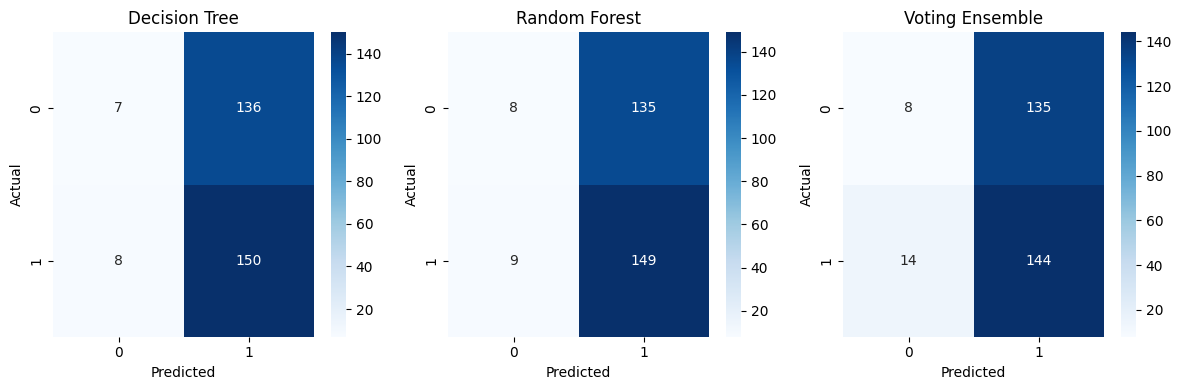

In [26]:
data = yf.download("^GSPC", start="2018-01-01", end="2024-01-01")
data['Return'] = data['Close'].pct_change()
data['Direction'] = (data['Return'] > 0).astype(int)

# Lag features
data['lag_1'] = data['Return'].shift(1)
data['lag_2'] = data['Return'].shift(2)
data['lag_3'] = data['Return'].shift(3)
data.dropna(inplace=True)

X = data[['lag_1', 'lag_2', 'lag_3']]
y = data['Direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Voting ensemble
voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svm', svm)],
    voting = 'soft')

models = {'Decision Tree': dt, 'Random Forest': rf, 'Voting Ensemble': voting}
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results[name] = {'accuracy': acc, 'f1': f1, 'cm': cm, 'auc': auc}

for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    print(f"F1-score: {metrics['f1']:.3f}")
    print("Confusion Matrix:")
    print(metrics['cm'])
    if metrics['auc'] is not None:
        print(f"AUC-ROC: {metrics['auc']:.3f}")

plt.figure(figsize = (12,4))
for i, (name, metrics) in enumerate(results.items(), 1):
    plt.subplot(1,3,i)
    sns.heatmap(metrics['cm'], annot=True, fmt="d", cmap='Blues')
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## **Code Block 8.9:**
**Comparison of Hard and Soft Voting Ensembles with Confusion Matrix Analysis**


Hard Voting Ensemble: Accuracy=51.50%, F1-score=0.668

Soft Voting Ensemble: Accuracy=50.50%, F1-score=0.659


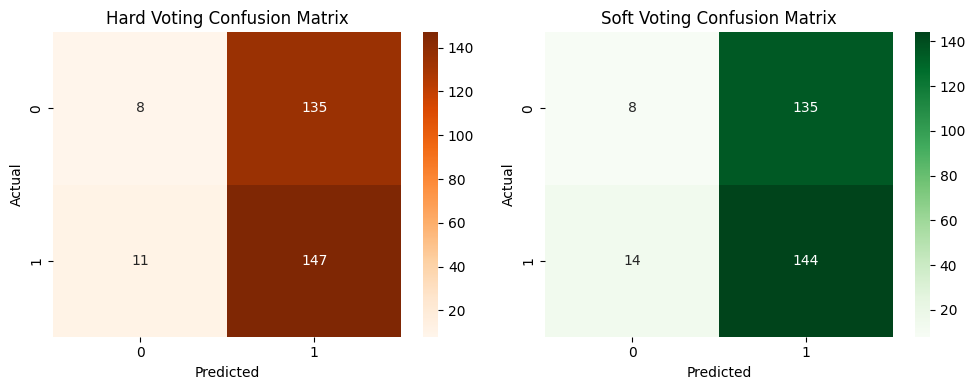

In [16]:
voting_hard = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svm', svm)],
    voting='hard')

voting_soft = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svm', svm)],
    voting='soft')

voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

# Predictions
y_pred_hard = voting_hard.predict(X_test_scaled)
y_pred_soft = voting_soft.predict(X_test_scaled)

def evaluate(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name}: Accuracy={acc:.2%}, F1-score={f1:.3f}")
    return cm

cm_hard = evaluate("Hard Voting Ensemble", y_test, y_pred_hard)
cm_soft = evaluate("Soft Voting Ensemble", y_test, y_pred_soft)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Oranges")
plt.title("Hard Voting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Greens")
plt.title("Soft Voting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()